In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
from tqdm import tqdm

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
y = train['ÏÑ±Í≥µÌôïÎ•†']
X_test = test.drop(columns=['ID'])

def build_model(input_dim, units, dropout_rates, lr, n_layers):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for i in range(n_layers):
        model.add(Dense(units[i], activation='relu'))
        model.add(Dropout(dropout_rates[i]))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])
    return model

def objective(trial):
    # Optuna ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÉòÌîåÎßÅ
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    epochs = trial.suggest_int('epochs', 100, 500)
    dropout_rates = [trial.suggest_float(f'dropout{i}', 0.0, 0.7) for i in range(1, 5)]
    units = [trial.suggest_int(f'units{i}', 16, 512) for i in range(1, 5)]
    n_layers = trial.suggest_int('n_layers', 3, 4)

    # 10-Fold ÍµêÏ∞®Í≤ÄÏ¶ù
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_mae_list = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = build_model(X.shape[1], units, dropout_rates, lr, n_layers)

        early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                  validation_data=(X_val, y_val), verbose=0, callbacks=[early_stop])

        val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
        fold_mae_list.append(val_loss)

    return np.mean(fold_mae_list)

# Optuna ÏµúÏ†ÅÌôî
n_trials = 100
study = optuna.create_study(direction='minimize')

with tqdm(total=n_trials) as pbar:
    def tqdm_callback(study, trial):
        pbar.update(1)
    study.optimize(objective, n_trials=n_trials, callbacks=[tqdm_callback])

# Í≤∞Í≥º Ï∂úÎ†•
print("Best trial:")
trial = study.best_trial
print(f"  Value (MAE): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
early_stop = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

model.fit(X, y, epochs=best_params['epochs'], batch_size=best_params['batch_size'],
          verbose=1, callbacks=[early_stop])

y_test_pred = model.predict(X_test_scaled).flatten()

submission = pd.DataFrame({
    'ID': test['ID'],
    'ÏÑ±Í≥µÌôïÎ•†': y_test_pred.clip(0, 1)
})

submission.to_csv('../../data/output/submission_long_tuning.csv', index=False)

[I 2025-05-25 00:53:16,758] A new study created in memory with name: no-name-d1fa7e6f-ebbe-4d32-aaab-0dafe8f78685
 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 66/100 [2:25:24<1:17:13, 136.26s/it]

In [ ]:
submission

train['ÏÑ±Í≥µÌôïÎ•†'].value_counts()

# ÌîÑÎ°úÏ†ùÌä∏ Í≥ÑÌöç ÏöîÏïΩ

## 1. Îç∞Ïù¥ÌÑ∞ Ïù¥Ìï¥ Î∞è Ï†ÑÏ≤òÎ¶¨
- ÏÑ±Í≥µÌôïÎ•†Ïù¥ 0.1 Îã®ÏúÑÎ°ú Íµ¨Î∂ÑÎêú Ïù¥ÏÇ∞Ìòï Í∞íÏûÑÏùÑ ÌôïÏù∏
- Î≤îÏ£ºÌòï Î≥ÄÏàò ÏõêÌï´ Ïù∏ÏΩîÎî©, ÏàòÏπòÌòï Î≥ÄÏàò Ï†ïÍ∑úÌôî Ï†ÅÏö©
- ÏÑ±Í≥µÌôïÎ•†ÏùÑ ÌÅ¥ÎûòÏä§(Î∂ÑÎ•ò Î†àÏù¥Î∏î)Î°ú Î≥ÄÌôò (Ïòà: 0.1 ‚Üí ÌÅ¥ÎûòÏä§ 1, 0.2 ‚Üí ÌÅ¥ÎûòÏä§ 2 ...)

## 2. Î¨∏Ï†ú Ï†ïÏùò
- ÏÑ±Í≥µÌôïÎ•† ÏòàÏ∏° ‚Üí ÌöåÍ∑ÄÎ≥¥Îã§Îäî Î∂ÑÎ•ò Î¨∏Ï†úÎ°ú Ï†ÑÌôòÌïòÏó¨ Ï†ëÍ∑º
- Îã§Ï§ë ÌÅ¥ÎûòÏä§ Î∂ÑÎ•ò Î¨∏Ï†úÎ°ú Î™®Îç∏ ÌïôÏäµ

## 3. Î™®Îç∏ÎßÅ
- Ïã†Í≤ΩÎßù Î™®Îç∏ ÏÑ§Í≥Ñ (MLP Í∏∞Î∞ò Îã§Ï§ë ÏùÄÎãâÏ∏µ)
- ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù (Optuna ÌôúÏö©)
  - ÏùÄÎãâÏ∏µ Ïàò, Ïú†Îãõ Ïàò, ÎìúÎ°≠ÏïÑÏõÉ ÎπÑÏú®, ÌïôÏäµÎ•†, Î∞∞ÏπòÏÇ¨Ïù¥Ï¶à, ÏóêÌè¨ÌÅ¨ Î≤îÏúÑ Îì± Ìè≠ÎÑìÍ≤å ÏÑ§Ï†ï
- Ï°∞Í∏∞ Ï¢ÖÎ£å(EarlyStopping) Ï†ÅÏö©

## 4. ÌïôÏäµ Î∞è Í≤ÄÏ¶ù
- ÍµêÏ∞®Í≤ÄÏ¶ù ÎòêÎäî Hold-out Í≤ÄÏ¶ùÏúºÎ°ú Í≥ºÏ†ÅÌï© Î∞©ÏßÄ Î∞è ÏùºÎ∞òÌôî ÌèâÍ∞Ä
- MAE Ïô∏ Î∂ÑÎ•ò Ï†ïÌôïÎèÑ Îì± Îã§ÏñëÌïú ÌèâÍ∞Ä ÏßÄÌëú ÌôúÏö©

## 5. ÏòàÏ∏° Î∞è Ï†úÏ∂ú
- ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ ÌÅ¥ÎûòÏä§ ÏòàÏ∏° ÏàòÌñâ
- ÏòàÏ∏° ÌÅ¥ÎûòÏä§ ‚Üí ÏÑ±Í≥µÌôïÎ•† Í∞íÏúºÎ°ú Îß§ÌïëÌïòÏó¨ Í≤∞Í≥º ÏÉùÏÑ±
- Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ± Î∞è ÌèâÍ∞Ä

## 6. Ìñ•ÌõÑ Í∞úÏÑ† Î∞è ÌôïÏû•
- Î∂ÑÎ•ò+ÌöåÍ∑Ä ÌòºÌï© Î™®Îç∏ Í≥†Î†§
- ÏÉòÌîå Í∞ÄÏ§ëÏπò, ÏÜêÏã§ Ìï®Ïàò Ïª§Ïä§ÌÑ∞ÎßàÏù¥Ïßï Îì± Î∂àÍ∑†Ìòï Î∞è ÎπÑÎåÄÏπ≠ Î∂ÑÌè¨ ÎåÄÏùë Ï†ÑÎûµ Ï†ÅÏö©
- Îã§ÏñëÌïú Ïã†Í≤ΩÎßù ÏïÑÌÇ§ÌÖçÏ≤ò Ïã§Ìóò (CNN, Transformer Îì±)

# Í∏∞Î≥∏ MLP Î™®Îç∏ Íµ¨ÏÑ± (ÏùÄÎãâÏ∏µ 2Í∞ú)
model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Ï∂úÎ†•Ï∏µ (ÌöåÍ∑Ä)

In [23]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
train = pd.read_csv("../../data/processed/feature_importance_test.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1755 non-null   object 
 1   ÏßÅÏõê Ïàò            1755 non-null   float64
 2   ÏßÅÏõêÎãπÎß§Ï∂ú           1755 non-null   float64
 3   Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú          1755 non-null   float64
 4   SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)  1755 non-null   float64
 5   Ïó∞Îß§Ï∂ú(ÏñµÏõê)         1755 non-null   float64
 6   Í≥†Í∞ùÎãπÎß§Ï∂ú           1755 non-null   float64
 7   Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)       1755 non-null   float64
 8   Ìà¨ÏûêÏàòÏùµÎπÑ           1755 non-null   float64
 9   Ìà¨ÏûêÎã®Í≥Ñ            1755 non-null   float64
dtypes: float64(9), object(1)
memory usage: 137.2+ KB


In [25]:
train['ÏÑ±Í≥µÌôïÎ•†'].value_counts()

KeyError: 'ÏÑ±Í≥µÌôïÎ•†'

In [ ]:
test.info()

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
y = train['ÏÑ±Í≥µÌôïÎ•†']
X_test = test.drop(columns=['ID'])

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
learning_rate = 0.0001112408115243152
batch_size = 16
epochs = 471
dropout1 = 0.06114446479113117
dropout2 = 0.00037525412817682874
dropout3 = 0.6447411638190662
dropout4 = 0.40273771947175707
units1 = 462
units2 = 466
units3 = 230
units4 = 248
n_layers = 3

# ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû•Ïö©
test_preds = np.zeros(len(X_test))
val_mae_list = []

# 10-Fold ÍµêÏ∞® Í≤ÄÏ¶ù ÏÑ§Ï†ï
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'\nüîÅ Fold {fold+1}')
    
    # Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Î™®Îç∏ Íµ¨ÏÑ±
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    model.add(Dense(units1, activation='relu'))
    model.add(Dropout(dropout1))
    
    if n_layers >= 2:
        model.add(Dense(units2, activation='relu'))
        model.add(Dropout(dropout2))
    
    if n_layers >= 3:
        model.add(Dense(units3, activation='relu'))
        model.add(Dropout(dropout3))
    
    if n_layers >= 4:
        model.add(Dense(units4, activation='relu'))
        model.add(Dropout(dropout4))
    
    model.add(Dense(1))  # Ï∂úÎ†•Ï∏µ

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error']
    )
    
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=0)
    
    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    
    # Í≤ÄÏ¶ù ÏÑ±Îä• Ï†ÄÏû•
    val_pred = model.predict(X_val).flatten()
    val_mae = mean_absolute_error(y_val, val_pred)
    val_mae_list.append(val_mae)
    print(f'üìâ Fold {fold+1} MAE: {val_mae:.4f}')
    
    # ÌÖåÏä§Ìä∏ ÏòàÏ∏° (Í∞Å fold Í≤∞Í≥º ÌèâÍ∑†)
    test_preds += model.predict(X_test).flatten() / kf.n_splits

# Ï†ÑÏ≤¥ Í≤ÄÏ¶ù Í≤∞Í≥º Ï∂úÎ†•
print(f'\n‚úÖ ÌèâÍ∑† Í≤ÄÏ¶ù MAE: {np.mean(val_mae_list):.4f} ¬± {np.std(val_mae_list):.4f}')

# Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
submission = pd.DataFrame({
    'ID': test['ID'],
    'ÏÑ±Í≥µÌôïÎ•†': test_preds.clip(0, 1)
})

submission.to_csv('../../data/output/submission_kfold_mlp_tuned.csv', index=False)


üîÅ Fold 1
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step 
üìâ Fold 1 MAE: 0.3112
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 613us/step

üîÅ Fold 2
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step 
üìâ Fold 2 MAE: 0.2944
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 609us/step

üîÅ Fold 3
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step 
üìâ Fold 3 MAE: 0.2916
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 606us/step

üîÅ Fold 4
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step 
üìâ Fold 4 MAE: 0.2793
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 605us/step

üîÅ Fold 5
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 2ms/step 
üìâ Fold 5 MAE: 0.2506
55/55 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 577us/step

üîÅ Fold

In [14]:
submission.head()

ID      ÏÑ±Í≥µÌôïÎ•†
0  TEST_0000  0.437475
1  TEST_0001  0.552629
2  TEST_0002  0.433878
3  TEST_0003  0.366867
4  TEST_0004  0.658146

# ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏

In [1]:
import pandas as pd
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              3800 non-null   object 
 1   ÏßÅÏõê Ïàò            3800 non-null   float64
 2   ÏßÅÏõêÎãπÎß§Ï∂ú           3800 non-null   float64
 3   Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú          3800 non-null   float64
 4   SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)  3800 non-null   float64
 5   Ïó∞Îß§Ï∂ú(ÏñµÏõê)         3800 non-null   float64
 6   Í≥†Í∞ùÎãπÎß§Ï∂ú           3800 non-null   float64
 7   Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)       3800 non-null   float64
 8   Ìà¨ÏûêÏàòÏùµÎπÑ           3800 non-null   float64
 9   Ìà¨ÏûêÎã®Í≥Ñ            3800 non-null   float64
 10  ÏÑ±Í≥µÌôïÎ•†            3800 non-null   float64
dtypes: float64(10), object(1)
memory usage: 326.7+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1755 non-null   object 
 1   ÏßÅÏõê Ïàò            1755 non-null   float64
 2   ÏßÅÏõêÎãπÎß§Ï∂ú           1755 non-null   float64
 3   Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú          1755 non-null   float64
 4   SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)  1755 non-null   float64
 5   Ïó∞Îß§Ï∂ú(ÏñµÏõê)         1755 non-null   float64
 6   Í≥†Í∞ùÎãπÎß§Ï∂ú           1755 non-null   float64
 7   Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)       1755 non-null   float64
 8   Ìà¨ÏûêÏàòÏùµÎπÑ           1755 non-null   float64
 9   Ìà¨ÏûêÎã®Í≥Ñ            1755 non-null   float64
dtypes: float64(9), object(1)
memory usage: 137.2+ KB


In [30]:
train.describe()

ÏßÅÏõê Ïàò        ÏßÅÏõêÎãπÎß§Ï∂ú       Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú  SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)      Ïó∞Îß§Ï∂ú(ÏñµÏõê)  \
count  3800.000000  3800.000000  3800.000000     3800.000000  3800.000000   
mean      0.493533     0.005068     0.004613        0.516223     0.434193   
std       0.284328     0.025564     0.031402        0.283111     0.255047   
min       0.000000     0.000000     0.000000        0.000000     0.000000   
25%       0.250100     0.000778     0.000615        0.270000     0.209504   
50%       0.493956     0.001553     0.001169        0.574000     0.433693   
75%       0.735079     0.003120     0.002816        0.800000     0.651452   
max       1.000000     1.000000     1.000000        1.000000     1.000000   

             Í≥†Í∞ùÎãπÎß§Ï∂ú    Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)        Ìà¨ÏûêÏàòÏùµÎπÑ         Ìà¨ÏûêÎã®Í≥Ñ        ÏÑ±Í≥µÌôïÎ•†  
count  3800.000000  3800.000000  3800.000000  3800.000000  3800.00000  
mean      0.023337     0.471231     0.006602     0.502961     0.53750  
std       0.060704     0.266475     0.035699     0.358600     0.24972  
min       0.000000     0.000000     0.000000     0.000000     0.10000  
25%       0.005859     0.236555     0.000972     0.250000     0.37500  
50%       0.011672     0.483894     0.001911     0.500000     0.55000  
75%       0.019920     0.694799     0.003596     0.750000     0.72500  
max       1.000000     1.000000     1.000000     1.000000     0.90000

In [31]:
test.describe()

ÏßÅÏõê Ïàò        ÏßÅÏõêÎãπÎß§Ï∂ú       Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú  SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)      Ïó∞Îß§Ï∂ú(ÏñµÏõê)  \
count  1755.000000  1755.000000  1755.000000     1755.000000  1755.000000   
mean      0.497039     0.005473     0.008120        0.507005     0.462029   
std       0.281365     0.038084     0.049571        0.278924     0.270300   
min       0.000000     0.000000     0.000000        0.000000     0.000000   
25%       0.262335     0.000628     0.000814        0.253000     0.228701   
50%       0.497039     0.001297     0.001491        0.512000     0.459616   
75%       0.737966     0.002645     0.003608        0.800000     0.693601   
max       1.000000     1.000000     1.000000        1.000000     1.000000   

             Í≥†Í∞ùÎãπÎß§Ï∂ú    Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)        Ìà¨ÏûêÏàòÏùµÎπÑ         Ìà¨ÏûêÎã®Í≥Ñ  
count  1755.000000  1755.000000  1755.000000  1755.000000  
mean      0.018801     0.457245     0.007956     0.505698  
std       0.040763     0.263459     0.034990     0.355618  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.005582     0.228888     0.001386     0.250000  
50%       0.010981     0.466093     0.002613     0.500000  
75%       0.018896     0.673833     0.005184     0.750000  
max       1.000000     1.000000     1.000000     1.000000

In [22]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
y = train['ÏÑ±Í≥µÌôïÎ•†']
X_test = test.drop(columns=['ID'])

# Base Î™®Îç∏Îì§
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

# Meta Î™®Îç∏
meta_model = Ridge(alpha=1.0)

# Stacking Î™®Îç∏ Íµ¨ÏÑ±
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# ÍµêÏ∞®Í≤ÄÏ¶ù Î∞è ÏòàÏ∏°
kf = KFold(n_splits=15, shuffle=True, random_state=42)
val_mae_list = []
test_preds = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nüå≤ Fold {fold+1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    stacked_model.fit(X_train, y_train)
    val_pred = stacked_model.predict(X_val)
    
    mae = mean_absolute_error(y_val, val_pred)
    val_mae_list.append(mae)
    print(f"üìâ Fold {fold+1} MAE: {mae:.4f}")
    
    test_preds += stacked_model.predict(X_test) / kf.n_splits

# ÏµúÏ¢Ö MAE Ï∂úÎ†•
print(f"\n‚úÖ ÌèâÍ∑† Í≤ÄÏ¶ù MAE: {np.mean(val_mae_list):.4f} ¬± {np.std(val_mae_list):.4f}")

# Í≤∞Í≥º Ï†ÄÏû•
submission = pd.DataFrame({
    'ID': test['ID'],
    'ÏÑ±Í≥µÌôïÎ•†': test_preds.clip(0, 1)
})
submission.to_csv('../../data/output/submission_stacking_gb_rf.csv', index=False)


üå≤ Fold 1
üìâ Fold 1 MAE: 0.2413

üå≤ Fold 2
üìâ Fold 2 MAE: 0.2360

üå≤ Fold 3
üìâ Fold 3 MAE: 0.2353

üå≤ Fold 4
üìâ Fold 4 MAE: 0.2253

üå≤ Fold 5
üìâ Fold 5 MAE: 0.2323

üå≤ Fold 6
üìâ Fold 6 MAE: 0.2210

üå≤ Fold 7
üìâ Fold 7 MAE: 0.2156

üå≤ Fold 8
üìâ Fold 8 MAE: 0.2269

üå≤ Fold 9
üìâ Fold 9 MAE: 0.2185

üå≤ Fold 10
üìâ Fold 10 MAE: 0.2451

üå≤ Fold 11
üìâ Fold 11 MAE: 0.2346

üå≤ Fold 12
üìâ Fold 12 MAE: 0.2333

üå≤ Fold 13
üìâ Fold 13 MAE: 0.2335

üå≤ Fold 14
üìâ Fold 14 MAE: 0.2338

üå≤ Fold 15
üìâ Fold 15 MAE: 0.2252

‚úÖ ÌèâÍ∑† Í≤ÄÏ¶ù MAE: 0.2305 ¬± 0.0080


# LightGBM

In [4]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
y = train['ÏÑ±Í≥µÌôïÎ•†']
X_test = test.drop(columns=['ID'])

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 15,
    'num_leaves': 64,
    'min_child_samples': 10,
    'min_gain_to_split': 0.0,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'random_state': 42,
    'n_jobs': -1
}

# ÏòàÏ∏° Í≤∞Í≥º Ï†ÄÏû•Ïö©
test_preds = np.zeros(len(X_test))
val_mae_list = []
fold_results = []  # üî• FoldÎ≥Ñ ÏÑ±Îä• Ï†ÄÏû•Ïö©

# 10-Fold ÍµêÏ∞® Í≤ÄÏ¶ù
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'\nüåø LGBM Fold {fold+1}')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    
    val_mae_list.append(val_mae)
    fold_results.append({'Fold': fold+1, 'MAE': val_mae})  # üî• ÏÑ±Îä• Í∏∞Î°ù
    
    print(f'üìâ Fold {fold+1} MAE: {val_mae:.4f}')
    
    test_preds += model.predict(X_test) / kf.n_splits

# ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞® Ï∂úÎ†•
mean_mae = np.mean(val_mae_list)
std_mae = np.std(val_mae_list)
print(f'\n‚úÖ ÌèâÍ∑† Í≤ÄÏ¶ù MAE: {mean_mae:.4f} ¬± {std_mae:.4f}')

# FoldÎ≥Ñ MAEÎ•º Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ïÎ¶¨
fold_results_df = pd.DataFrame(fold_results)
print("\nüìã FoldÎ≥Ñ MAE:")
print(fold_results_df)

# ÌïÑÏöî Ïãú Ï†ÄÏû•
# fold_results_df.to_csv('../../data/output/fold_mae_lgbm.csv', index=False)

# Ï†úÏ∂ú ÌååÏùº Ï†ÄÏû•
submission = pd.DataFrame({
    'ID': test['ID'],
    'ÏÑ±Í≥µÌôïÎ•†': test_preds.clip(0, 1)
})
submission.to_csv('../../data/output/submission_kfold_lgbm.csv', index=False)


üåø LGBM Fold 1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

# XGBoost

In [11]:
import pandas as pd
# Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
train = pd.read_csv("../../data/processed/feature_importance_train.csv")
test = pd.read_csv("../../data/processed/feature_importance_test.csv")

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              3800 non-null   object 
 1   Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)       3800 non-null   float64
 2   Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú          3800 non-null   float64
 3   ÏßÅÏõê Ïàò            3800 non-null   float64
 4   Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò        3800 non-null   float64
 5   ÏßÅÏõêÎãπÎß§Ï∂ú           3800 non-null   float64
 6   SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)  3800 non-null   float64
 7   Í≥†Í∞ùÎãπÎß§Ï∂ú           3800 non-null   float64
 8   Ìà¨ÏûêÏàòÏùµÎπÑ           3800 non-null   float64
 9   Ïó∞Îß§Ï∂ú(ÏñµÏõê)         3800 non-null   float64
 10  Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)        3800 non-null   float64
 11  ÏÑ§Î¶ΩÏó∞ÎèÑ            3800 non-null   float64
 12  Í∏∞ÏóÖÎÇòÏù¥            3800 non-null   float64
 13  Ìà¨ÏûêÎã®Í≥Ñ            3800 non-null   float64
 14  Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)       38

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1755 non-null   object 
 1   Ï¥ù Ìà¨ÏûêÍ∏à(ÏñµÏõê)       1755 non-null   int64  
 2   Í∞ÄÏπòÎåÄÎπÑÎß§Ï∂ú          1755 non-null   float64
 3   ÏßÅÏõê Ïàò            1755 non-null   float64
 4   Ï¥ùÌà¨ÏûêÍ∏àÎãπÏßÅÏõêÏàò        1755 non-null   float64
 5   ÏßÅÏõêÎãπÎß§Ï∂ú           1755 non-null   float64
 6   SNS ÌåîÎ°úÏõå Ïàò(Î∞±ÎßåÎ™Ö)  1755 non-null   float64
 7   Í≥†Í∞ùÎãπÎß§Ï∂ú           1755 non-null   float64
 8   Ìà¨ÏûêÏàòÏùµÎπÑ           1755 non-null   float64
 9   Ïó∞Îß§Ï∂ú(ÏñµÏõê)         1755 non-null   int64  
 10  Í≥†Í∞ùÏàò(Î∞±ÎßåÎ™Ö)        1755 non-null   float64
 11  ÏÑ§Î¶ΩÏó∞ÎèÑ            1755 non-null   int64  
 12  Í∏∞ÏóÖÎÇòÏù¥            1755 non-null   int64  
 13  Ìà¨ÏûêÎã®Í≥Ñ            1755 non-null   int64  
 14  Í∏∞ÏóÖÍ∞ÄÏπò(Î∞±ÏñµÏõê)       17

In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
y = train['ÏÑ±Í≥µÌôïÎ•†']
X_test = test.drop(columns=['ID'])

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'gamma': 0,
    'random_state': 42,
    'n_jobs': -1
}

test_preds = np.zeros(len(X_test))
val_mae_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'\nüî• XGBoost Fold {fold+1}')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=100)
    
    val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    val_mae_list.append(val_mae)
    print(f'üìâ Fold {fold+1} MAE: {val_mae:.4f}')
    
    test_preds += model.predict(X_test) / kf.n_splits

print(f'\n‚úÖ ÌèâÍ∑† Í≤ÄÏ¶ù MAE: {np.mean(val_mae_list):.4f} ¬± {np.std(val_mae_list):.4f}')

submission = pd.DataFrame({
    'ID': test['ID'],
    'ÏÑ±Í≥µÌôïÎ•†': test_preds.clip(0, 1)
})
submission.to_csv('../../data/output/submission_xgb.csv', index=False)


üî• XGBoost Fold 1
üìâ Fold 1 MAE: 0.2175

üî• XGBoost Fold 2
üìâ Fold 2 MAE: 0.2108

üî• XGBoost Fold 3
üìâ Fold 3 MAE: 0.2054

üî• XGBoost Fold 4
üìâ Fold 4 MAE: 0.1968

üî• XGBoost Fold 5
üìâ Fold 5 MAE: 0.1961

üî• XGBoost Fold 6
üìâ Fold 6 MAE: 0.2167

üî• XGBoost Fold 7
üìâ Fold 7 MAE: 0.2121

üî• XGBoost Fold 8
üìâ Fold 8 MAE: 0.2070

üî• XGBoost Fold 9
üìâ Fold 9 MAE: 0.2084

üî• XGBoost Fold 10
üìâ Fold 10 MAE: 0.2018

‚úÖ ÌèâÍ∑† Í≤ÄÏ¶ù MAE: 0.2073 ¬± 0.0071


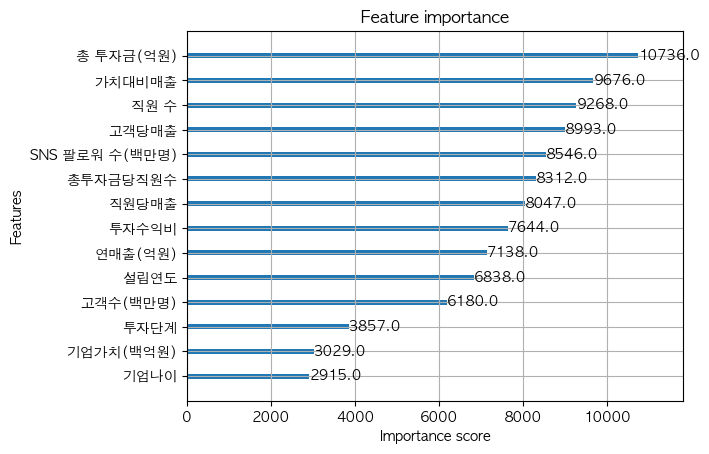

In [26]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
#Îß•ÏóêÏÑú ÌïúÍ∏Ä ÏïàÍπ®ÏßÄÍ≤å


rc('font', family='AppleGothic') # Ïï†Ìîå Ìè∞Ìä∏ ÏÇ¨Ïö©
plt.rcParams['axes.unicode_minus'] = False # ÎßàÏù¥ÎÑàÏä§ Î∂ÄÌò∏ ÏïàÍπ®ÏßÄÍ≤å ÏÑ§Ï†ï

xgb.plot_importance(model)
plt.show()

## XGBoost ÏÑ±Í≥µÌôïÎ•†

In [30]:
submission.describe()

ÏÑ±Í≥µÌôïÎ•†
count  1755.000000
mean      0.494981
std       0.007452
min       0.456091
25%       0.495181
50%       0.495181
75%       0.495181
max       0.531470

In [41]:
train.shape

(3800, 11)

In [42]:
test.shape

(1755, 10)

In [25]:
import pandas as pd

# FoldÎ≥Ñ MAE Í∞í
lgbm_mae = [0.222366, 0.218781, 0.206600, 0.195580, 0.204213,
            0.220160, 0.216011, 0.213723, 0.209895, 0.206095]

nn_mae = [0.3112, 0.2944, 0.2916, 0.2793, 0.2506,
          0.2952, 0.2897, 0.2693, 0.2740, 0.2749]

rf_mae = [0.2413, 0.2360, 0.2353, 0.2253, 0.2323,
          0.2210, 0.2156, 0.2269, 0.2185, 0.2451]

xgb_mae = [0.2218, 0.2125, 0.2049, 0.1970, 0.1959,
           0.2126, 0.2073, 0.2082, 0.2053, 0.2022]

# Fold Î≤àÌò∏ (LGBM, NN, XGBÎäî 10Í∞ú, RFÎäî 15Í∞ú)
fold_lgbm = list(range(1, 11))
fold_rf = list(range(1, 11))

# ÌÜµÌï© Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
mae_df = pd.DataFrame({
    'Fold': fold_lgbm + fold_lgbm + fold_rf + fold_lgbm,
    'Model': ['MLP'] * 10 + ['LGBM'] * 10 + ['Random Forest'] * 10 + ['XGBoost'] * 10,
    'MAE': nn_mae + lgbm_mae + rf_mae + xgb_mae
})

# ÌôïÏù∏
#rint(mae_df)

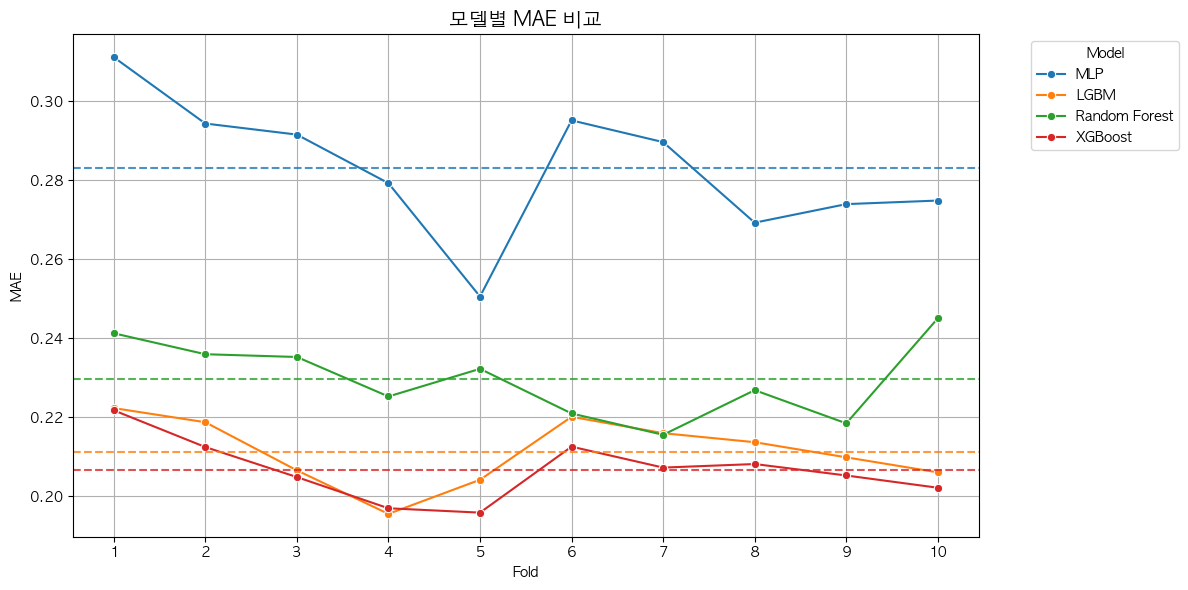

In [28]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import warnings
import pandas as pd

# ÏÑ§Ï†ï
warnings.simplefilter(action='ignore', category=FutureWarning)
rc('font', family='AppleGothic')  # Ïï†Ìîå Ìè∞Ìä∏ ÏÇ¨Ïö©
plt.rcParams['axes.unicode_minus'] = False

# Î™®Îç∏Î≥Ñ ÌèâÍ∑† MAE Í≥ÑÏÇ∞
model_avg_df = mae_df.groupby('Model')['MAE'].mean().reset_index()
model_avg_df['Fold'] = 'ÌèâÍ∑†'  # ÏãúÍ∞ÅÌôîÏóêÎäî ÏÇ¨Ïö© ÏïàÌï®. Ï∞∏Í≥†Ïö©.

plt.figure(figsize=(12, 6))

# ÌåîÎ†àÌä∏ ÎØ∏Î¶¨ Î∞õÏïÑÏò§Í∏∞ (Î™®Îç∏ ÏàòÏóê ÎßûÍ≤å)
unique_models = mae_df['Model'].unique()
palette = sns.color_palette(n_colors=len(unique_models))

# Î™®Îç∏Î™Ö-ÏÉâÏÉÅ Îß§Ìïë ÎîïÏÖîÎÑàÎ¶¨ ÏÉùÏÑ±
model_color_dict = dict(zip(unique_models, palette))

# ÎùºÏù∏ÌîåÎ°Ø Í∑∏Î¶¨Í∏∞ (ÌåîÎ†àÌä∏ ÏßÄÏ†ï)
sns.lineplot(data=mae_df, x='Fold', y='MAE', hue='Model', marker='o', palette=model_color_dict)

# Î™®Îç∏Î≥Ñ ÌèâÍ∑† MAE ÏàòÌèâÏÑ† Ï∂îÍ∞Ä (ÏÉâÏÉÅ ÎèôÏùºÌïòÍ≤å)
for _, row in model_avg_df.iterrows():
    plt.axhline(y=row['MAE'], linestyle='--', alpha=0.8, color=model_color_dict[row['Model']])

plt.title('Î™®Îç∏Î≥Ñ MAE ÎπÑÍµê', fontsize=14)
plt.xticks(mae_df['Fold'].unique())
plt.grid(True)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ÏÑ†ÌòïÎ™®Îç∏

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Îç∞Ïù¥ÌÑ∞
X = train.drop(columns=['ID', 'ÏÑ±Í≥µÌôïÎ•†'])
y = train['ÏÑ±Í≥µÌôïÎ•†']
X_test = test.drop(columns=['ID'])

# Í≤∞Í≥º Ï†ÄÏû•Ïö©
test_preds = np.zeros(len(X_test))
val_mae_list = []

# ÍµêÏ∞®Í≤ÄÏ¶ù ÏÑ§Ï†ï
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# ÍµêÏ∞®Í≤ÄÏ¶ù
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'\nüìê LinearRegression Fold {fold+1}')
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)

    val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_pred)
    val_mae_list.append(val_mae)
    print(f'üìâ Fold {fold+1} MAE: {val_mae:.4f}')

    test_preds += model.predict(X_test) / kf.n_splits

print(f'\n‚úÖ ÌèâÍ∑† Í≤ÄÏ¶ù MAE: {np.mean(val_mae_list):.4f} ¬± {np.std(val_mae_list):.4f}')

# Í≤∞Í≥º Ï†ÄÏû•
submission = pd.DataFrame({
    'ID': test['ID'],
    'ÏÑ±Í≥µÌôïÎ•†': test_preds.clip(0, 1)
})
submission.to_csv('../../data/output/submission_linear.csv', index=False)


üìê LinearRegression Fold 1
üìâ Fold 1 MAE: 0.2272

üìê LinearRegression Fold 2
üìâ Fold 2 MAE: 0.2151

üìê LinearRegression Fold 3
üìâ Fold 3 MAE: 0.2117

üìê LinearRegression Fold 4
üìâ Fold 4 MAE: 0.2013

üìê LinearRegression Fold 5
üìâ Fold 5 MAE: 0.1985

üìê LinearRegression Fold 6
üìâ Fold 6 MAE: 0.2147

üìê LinearRegression Fold 7
üìâ Fold 7 MAE: 0.2213

üìê LinearRegression Fold 8
üìâ Fold 8 MAE: 0.2150

üìê LinearRegression Fold 9
üìâ Fold 9 MAE: 0.2177

üìê LinearRegression Fold 10
üìâ Fold 10 MAE: 0.2040

‚úÖ ÌèâÍ∑† Í≤ÄÏ¶ù MAE: 0.2126 ¬± 0.0085


In [24]:
submission.describe()

ÏÑ±Í≥µÌôïÎ•†
count  1755.000000
mean      0.243626
std       0.428791
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000